In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px

In [3]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/train.csv", parse_dates=['time'])
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/test.csv", parse_dates=['time'])

elements = [e for e in train_df.columns if e!='row_id' and e!='congestion']
train_df.shape, test_df.shape

((848835, 6), (2340, 5))

In [4]:
train_df.head()

row_id       time  x  y direction  congestion
0       0 1991-04-01  0  0        EB          70
1       1 1991-04-01  0  0        NB          49
2       2 1991-04-01  0  0        SB          24
3       3 1991-04-01  0  1        EB          18
4       4 1991-04-01  0  1        NB          60

In [5]:
train_df.time.unique() 
# date range : 1991-04-01 ~ 1991-09-30 11:40:00
# time span 20 mins  (00:00:00, 00:20:00, 00:40:00)

array(['1991-04-01T00:00:00.000000000', '1991-04-01T00:20:00.000000000',
       '1991-04-01T00:40:00.000000000', ...,
       '1991-09-30T11:00:00.000000000', '1991-09-30T11:20:00.000000000',
       '1991-09-30T11:40:00.000000000'], dtype='datetime64[ns]')

In [6]:
test_df.head()

row_id                time  x  y direction
0  848835 1991-09-30 12:00:00  0  0        EB
1  848836 1991-09-30 12:00:00  0  0        NB
2  848837 1991-09-30 12:00:00  0  0        SB
3  848838 1991-09-30 12:00:00  0  1        EB
4  848839 1991-09-30 12:00:00  0  1        NB

In [7]:
test_df.time.unique() 
# predict congestion on 1991-09-30 between 12:00:00 and 23:40:00

array(['1991-09-30T12:00:00.000000000', '1991-09-30T12:20:00.000000000',
       '1991-09-30T12:40:00.000000000', '1991-09-30T13:00:00.000000000',
       '1991-09-30T13:20:00.000000000', '1991-09-30T13:40:00.000000000',
       '1991-09-30T14:00:00.000000000', '1991-09-30T14:20:00.000000000',
       '1991-09-30T14:40:00.000000000', '1991-09-30T15:00:00.000000000',
       '1991-09-30T15:20:00.000000000', '1991-09-30T15:40:00.000000000',
       '1991-09-30T16:00:00.000000000', '1991-09-30T16:20:00.000000000',
       '1991-09-30T16:40:00.000000000', '1991-09-30T17:00:00.000000000',
       '1991-09-30T17:20:00.000000000', '1991-09-30T17:40:00.000000000',
       '1991-09-30T18:00:00.000000000', '1991-09-30T18:20:00.000000000',
       '1991-09-30T18:40:00.000000000', '1991-09-30T19:00:00.000000000',
       '1991-09-30T19:20:00.000000000', '1991-09-30T19:40:00.000000000',
       '1991-09-30T20:00:00.000000000', '1991-09-30T20:20:00.000000000',
       '1991-09-30T20:40:00.000000000', '1991-09-30

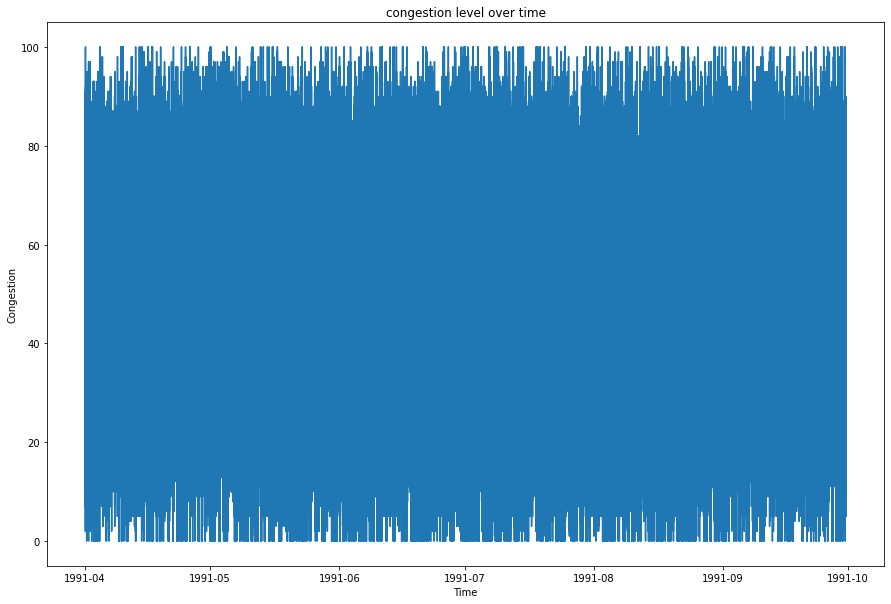

In [8]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(train_df['time'], train_df['congestion'])
ax.set_ylabel('Congestion')
ax.set_xlabel('Time')
ax.set_title('congestion level over time')
plt.show()
# no missing data

In [9]:
for col in elements:
    msg = 'column: {:>10}\t Percent of NAN value: {:.2f}%'.format(col, 100 * (train_df[col].isnull().sum()/train_df[col].shape[0]))
    print(msg)
# no null value    

column:       time	 Percent of NAN value: 0.00%
column:          x	 Percent of NAN value: 0.00%
column:          y	 Percent of NAN value: 0.00%
column:  direction	 Percent of NAN value: 0.00%


In [10]:
# drop holidays - the date we would predict on is not holiday
from datetime import date
import holidays

def isHoliday(d) :    
    us_holidays = holidays.US()
    return d in us_holidays

In [11]:
train_df.time.dt.date

0         1991-04-01
1         1991-04-01
2         1991-04-01
3         1991-04-01
4         1991-04-01
             ...    
848830    1991-09-30
848831    1991-09-30
848832    1991-09-30
848833    1991-09-30
848834    1991-09-30
Name: time, Length: 848835, dtype: object

In [12]:
train_df[train_df["time"].apply(lambda x:isHoliday(x))].time.dt.date.unique()
# holiday - May 27, Jun 4, Sep 2

array([datetime.date(1991, 5, 27), datetime.date(1991, 7, 4),
       datetime.date(1991, 9, 2)], dtype=object)

In [13]:
train_df.shape

(848835, 6)

In [14]:
train_df.drop(train_df[train_df["time"].apply(lambda x:isHoliday(x))].index, inplace=True)
train_df.shape
# 14040 rows dropped

(834795, 6)

In [15]:
test_df[test_df["time"].apply(lambda x:isHoliday(x))].time.dt.date.unique()
# there is no holiday in test data

array([], dtype=object)

In [16]:
train_df.direction.unique()
#8 directions

array(['EB', 'NB', 'SB', 'WB', 'NE', 'SW', 'NW', 'SE'], dtype=object)

In [17]:
train_df.groupby(['x','y']).size()
# 12 location

x  y
0  0     38529
   1     51372
   2     51372
   3     77058
1  0     77058
   1     51372
   2     77058
   3     77058
2  0     51372
   1    102744
   2    102744
   3     77058
dtype: int64

In [18]:
train_df.groupby(['x','y','direction']).size()
# 65 directions * locations, has same size

x  y  direction
0  0  EB           12843
      NB           12843
      SB           12843
   1  EB           12843
      NB           12843
                   ...  
2  3  NB           12843
      NE           12843
      SB           12843
      SW           12843
      WB           12843
Length: 65, dtype: int64

In [19]:
test_df.groupby(['x','y','direction']).size()
# 65 directions * locations, has same size

x  y  direction
0  0  EB           36
      NB           36
      SB           36
   1  EB           36
      NB           36
                   ..
2  3  NB           36
      NE           36
      SB           36
      SW           36
      WB           36
Length: 65, dtype: int64

In [20]:
train_df.congestion.value_counts()


34    25989
40    19423
47    19086
29    18805
48    18680
      ...  
95      139
97      103
98       87
1        48
99       42
Name: congestion, Length: 101, dtype: int64

In [21]:
#np.unique(train_df.congestion)

#from collections import Counter
#Counter(np.unique(train_df.congestion)).values() # counts the elements' frequency

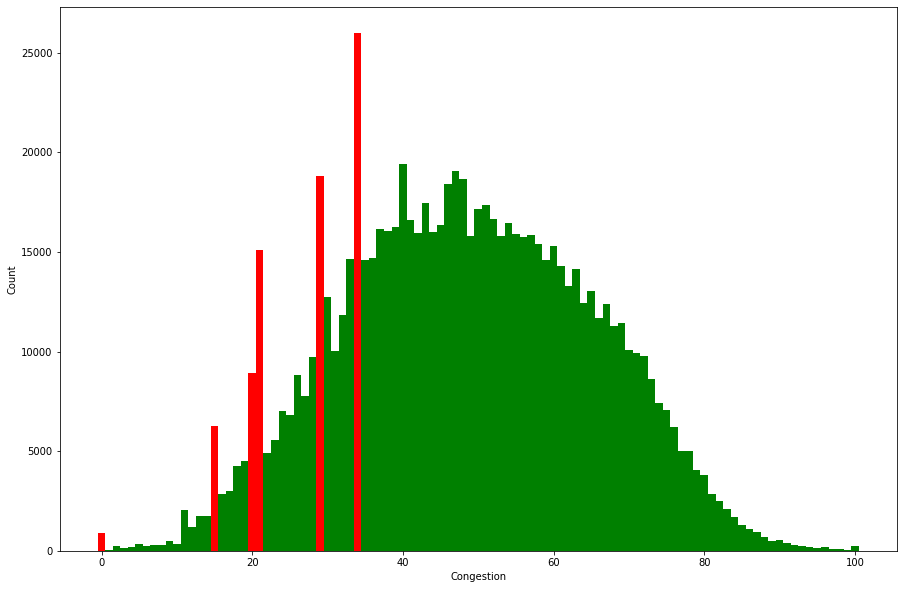

In [22]:
plt.figure(figsize=(15, 10))
plt.bar(range(101), train_df.congestion.value_counts().sort_index(), width=1,
       color=['red' if con in [0,15,20,21,29,34] else 'green' for con in range(101)])
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()

In [23]:
# explorer data for each direction
train_df_pivot = train_df.pivot_table(values='congestion', index=train_df.time, columns='direction', aggfunc='first')
train_df_pivot.head()
# train_df_eb = train_df.loc[train_df.direction=='EB'].filter(['time', 'congestion'], axis=1)

direction            EB  NB  NE  NW  SB  SE  SW  WB
time                                               
1991-04-01 00:00:00  70  49  21  29  24  34  47  26
1991-04-01 00:20:00  70  49  17  29  24  34  48  57
1991-04-01 00:40:00  70  49  46  29  24  34  15  91
1991-04-01 01:00:00  70  49  50  29  24  34  31  49
1991-04-01 01:20:00  70  49  50  29  24  34  19  62

In [24]:
import plotly.express as px
fig = px.area(train_df_pivot, facet_col="direction", facet_col_wrap=2,             
              title='congestion for direction over time')
fig.show()

#SE - congestion is quite stable

In [25]:
train_df_pivot.reset_index(drop=False, inplace=True)
train_df_pivot.head()

direction                time  EB  NB  NE  NW  SB  SE  SW  WB
0         1991-04-01 00:00:00  70  49  21  29  24  34  47  26
1         1991-04-01 00:20:00  70  49  17  29  24  34  48  57
2         1991-04-01 00:40:00  70  49  46  29  24  34  15  91
3         1991-04-01 01:00:00  70  49  50  29  24  34  31  49
4         1991-04-01 01:20:00  70  49  50  29  24  34  19  62

In [26]:
fig = px.line(train_df_pivot, x="time", y=train_df_pivot.columns,
              hover_data={"time": "|%B %d, %Y %H:%M"},
              title='congestion for direction over time')
fig.update_xaxes(dtick="M1", tickformat="%b\n%Y")
fig.show()

In [27]:
# date split
train_df["year"] = train_df.time.dt.year
train_df["month"] = train_df.time.dt.month
train_df["day"] = train_df.time.dt.day
#train_df["season"] = np.where(train_df.time.dt.month.isin([3,4,5]), "spring",
#                    np.where(train_df.time.dt.month.isin([6,7,8]), "summer", 
#                    np.where(train_df.time.dt.month.isin([9,10,11]), "autumn", 
#                    np.where(train_df.time.dt.month.isin([12,1,2]), "winter", "none"))))
#train_df.drop("time", axis=1)

test_df["year"] = test_df.time.dt.year
test_df["month"] = test_df.time.dt.month
test_df["day"] = test_df.time.dt.day

train_df.head(), train_df.shape

(   row_id       time  x  y direction  congestion  year  month  day
 0       0 1991-04-01  0  0        EB          70  1991      4    1
 1       1 1991-04-01  0  0        NB          49  1991      4    1
 2       2 1991-04-01  0  0        SB          24  1991      4    1
 3       3 1991-04-01  0  1        EB          18  1991      4    1
 4       4 1991-04-01  0  1        NB          60  1991      4    1,
 (834795, 9))

In [28]:
# normalize 
#congestion = train_df["congestion"]
#base_norm = (congestion - congestion.min()) / (congestion.max() - congestion.min())
#train_df["congestion_norm"] = base_norm
#train_df.head()

## random forest

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_df['direction_num'] = le.fit_transform(train_df['direction'])
test_df['direction_num'] = le.fit_transform(test_df['direction'])

In [30]:
y_train = train_df['congestion']

In [31]:
feature_names = ['year', 'month', 'day', 'x', 'y', 'direction_num']
X_train = train_df[feature_names]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# cross validation
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state = 1)

In [33]:
import time
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

start_time = time.process_time()
rfModel.fit(train_X, train_y)
print(time.process_time() - start_time, " seconds")

rfPredict = rfModel.predict(val_X)
rfMbe = mean_absolute_error(val_y, rfPredict)
print("MAE:", rfMbe)

60.99556241099998  seconds
MAE: 8.171554801808231


In [34]:
X_test = test_df[feature_names]
rfPredict = rfModel.predict(X_test)

## LightGBM

In [35]:
import lightgbm as lgb

lgbModel = lgb.LGBMClassifier()

start_time = time.process_time()
lgbModel.fit(train_X, train_y)
print(time.process_time() - start_time, " seconds")

lgbPredict = lgbModel.predict(val_X) 
lgbMbe = mean_absolute_error(val_y, lgbPredict)

print("MAE:", lgbMbe)
print("Accuracy:",metrics.accuracy_score(val_y, lgbPredict))


675.9985439090001  seconds
MAE: 15.780325747986536
Accuracy: 0.026641218021154853


In [36]:
X_test = test_df[feature_names]
Predict = lgbModel.predict(X_test)

## submission

In [37]:
submission = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv")
submission.head()

row_id  congestion
0  848835         0.0
1  848836         0.0
2  848837         0.0
3  848838         0.0
4  848839         0.0

In [38]:
submission["congestion"] = rfPredict
submission["congestion"] = submission["congestion"].round().astype(int)
assert(submission["congestion"] >= 0).all()
assert(submission["congestion"] <= 100).all()
submission.head()

row_id  congestion
0  848835          42
1  848836          32
2  848837          54
3  848838          25
4  848839          63

In [39]:
submission.to_csv("./submission_{0:.1f}.csv".format(rfMbe), index=False)